In [6]:
import geopandas as gpd
import os

svi_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/social_vul/NewYork.csv'
svi = gpd.read_file(svi_path)

census_tracts_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/land_parcels/census_tracts_2020/nyct2020.shp'
census_tracts = gpd.read_file(census_tracts_path)


In [11]:
# Extract census tract number from LOCATION column
# Format example: "Census Tract 1; Albany County; New York"
# We need to extract the number after "Census Tract "
import pandas as pd

# Extract the tract number from LOCATION column
svi['tract_number'] = svi['LOCATION'].str.extract(r'Census Tract ([\d.]+)', expand=False)

# Display sample to verify extraction
print("Sample LOCATION values:")
print(svi[['LOCATION', 'tract_number']].head())

# Check for any missing extractions
print(f"\nMissing tract numbers: {svi['tract_number'].isna().sum()}")

Sample LOCATION values:
                                     LOCATION tract_number
0     Census Tract 1; Albany County; New York            1
1  Census Tract 2.01; Albany County; New York         2.01
2  Census Tract 2.02; Albany County; New York         2.02
3  Census Tract 3.01; Albany County; New York         3.01
4  Census Tract 3.02; Albany County; New York         3.02

Missing tract numbers: 0


In [12]:
# Display sample census tract data to understand the CTLabel format
print("Sample census tract CTLabel values:")
print(census_tracts[['CTLabel']].head(10))
print(f"\nTotal census tracts: {len(census_tracts)}")

Sample census tract CTLabel values:
  CTLabel
0       1
1   14.01
2   14.02
3      18
4   22.01
5   26.02
6      28
7      34
8   36.01
9   36.02

Total census tracts: 2325


In [13]:
# Perform the join based on tract numbers
# The merge creates geometry_x (from census_tracts) and geometry_y (from svi)
svi_with_geometry = census_tracts.merge(
    svi,
    left_on='CTLabel',
    right_on='tract_number',
    how='inner'
)

# Keep only geometry_x (from census_tracts) and rename it to geometry
svi_with_geometry = svi_with_geometry.rename(columns={'geometry_x': 'geometry'})

# Drop geometry_y as we don't need it
if 'geometry_y' in svi_with_geometry.columns:
    svi_with_geometry = svi_with_geometry.drop(columns=['geometry_y'])

# Convert to GeoDataFrame
svi_with_geometry = gpd.GeoDataFrame(svi_with_geometry, geometry='geometry', crs=census_tracts.crs)

print(f"Original SVI records: {len(svi)}")
print(f"Census tracts: {len(census_tracts)}")
print(f"Merged records: {len(svi_with_geometry)}")
print(f"Is GeoDataFrame: {isinstance(svi_with_geometry, gpd.GeoDataFrame)}")
print(f"\nSample of merged data:")
print(svi_with_geometry[['CTLabel', 'tract_number', 'LOCATION']].head())

Original SVI records: 5394
Census tracts: 2325
Merged records: 6816
Is GeoDataFrame: True

Sample of merged data:
  CTLabel tract_number                                   LOCATION
0       1            1    Census Tract 1; Albany County; New York
1       1            1     Census Tract 1; Bronx County; New York
2       1            1    Census Tract 1; Broome County; New York
3       1            1   Census Tract 1; Chemung County; New York
4       1            1  Census Tract 1; Columbia County; New York


In [14]:
# Save the merged data as a shapefile in the same folder as svi_path
output_folder = os.path.dirname(svi_path)
output_path = os.path.join(output_folder, 'NewYork_SVI_with_geometry.shp')

# Save as shapefile
svi_with_geometry.to_file(output_path)

print(f"Shapefile saved to: {output_path}")
print(f"Files created:")
for file in os.listdir(output_folder):
    if file.startswith('NewYork_SVI_with_geometry'):
        print(f"  - {file}")

/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_62651/93119239.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  svi_with_geometry.to_file(output_path)


Shapefile saved to: /Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/social_vul/NewYork_SVI_with_geometry.shp
Files created:
  - NewYork_SVI_with_geometry.shx
  - NewYork_SVI_with_geometry.shp
  - NewYork_SVI_with_geometry.cpg
  - NewYork_SVI_with_geometry.dbf
  - NewYork_SVI_with_geometry.prj


In [11]:
import geopandas as gpd

building_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/land_parcels/property_plots/staten_island.shp'
amenities_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/amenities/nyc_amenities.shp'

# buildings = gpd.read_file(building_path)
# amenities = gpd.read_file(amenities_path)

buildings_copy = buildings.copy()
amenities_copy = amenities.copy()

In [12]:
import pandas as pd

# Step 1: Add district type column based on ZoneDist1
# Extract first character and map to district type based on the key provided

def get_district_type(zone_code):
    """
    Classify zoning district based on first character(s)
    R1-1 - R10H: Residential Districts
    C1-6 - C8-4: Commercial Districts
    M1-1 - M3-2: Manufacturing Districts
    M1-1/R5 - M1-9/R12: Mixed Manufacturing & Residential Districts
    BPC: Battery Park City
    PARK: Areas designated as PARK, BALL FIELD, PLAYGROUND and PUBLIC SPACE
    """
    if pd.isna(zone_code) or zone_code == '':
        return 'Unknown'
    
    zone_str = str(zone_code).strip().upper()
    
    # Check for specific patterns
    if zone_str.startswith('R'):
        # Check if it's mixed (contains '/')
        if '/' in zone_str:
            return 'Mixed Manufacturing & Residential'
        return 'Residential'
    elif zone_str.startswith('C'):
        return 'Commercial'
    elif zone_str.startswith('M'):
        # Check if it's mixed (contains '/')
        if '/' in zone_str:
            return 'Mixed Manufacturing & Residential'
        return 'Manufacturing'
    elif 'BPC' in zone_str:
        return 'Battery Park City'
    elif 'PARK' in zone_str or 'BALL' in zone_str or 'PLAYGROUND' in zone_str or 'PUBLIC SPACE' in zone_str:
        return 'Park/Public Space'
    else:
        return 'Other'

# Apply the function to create the district_type column
buildings_copy['district_type'] = buildings_copy['ZoneDist1'].apply(get_district_type)

print("District type distribution:")
print(buildings_copy['district_type'].value_counts())
print("\nSample of buildings with new district_type column:")
print(buildings_copy[['ZoneDist1', 'district_type']].head(20))


District type distribution:
district_type
Residential          120617
Manufacturing          2344
Commercial             1497
Park/Public Space       991
Name: count, dtype: int64

Sample of buildings with new district_type column:
   ZoneDist1      district_type
0       C4-2         Commercial
1       C4-2         Commercial
2       C4-2         Commercial
3       M1-1      Manufacturing
4         C3         Commercial
5       C4-2         Commercial
6       C4-2         Commercial
7       C4-2         Commercial
8       C4-2         Commercial
9       C4-2         Commercial
10      C4-2         Commercial
11      M1-1      Manufacturing
12      M1-1      Manufacturing
13      PARK  Park/Public Space
14      M1-1      Manufacturing
15      M1-1      Manufacturing
16      M1-1      Manufacturing
17      M1-1      Manufacturing
18      M1-1      Manufacturing
19      PARK  Park/Public Space


In [13]:
# Step 2: Add amenity presence column
# Check if any amenity point is within each building polygon

print("Checking CRS compatibility...")
print(f"Buildings CRS: {buildings_copy.crs}")
print(f"Amenities CRS: {amenities_copy.crs}")

# Ensure both datasets have the same CRS
if buildings_copy.crs != amenities_copy.crs:
    print(f"Converting amenities to buildings CRS...")
    amenities_copy = amenities_copy.to_crs(buildings_copy.crs)
    print("Conversion complete")

# Perform spatial join to find which buildings contain amenities
print("\nPerforming spatial join to find amenities within buildings...")
print(f"This may take a while with {len(buildings_copy)} buildings and {len(amenities_copy)} amenities...")

# First, do the spatial join
buildings_with_amenities = gpd.sjoin(
    buildings_copy,
    amenities_copy[['geometry']],  # Only need geometry column from amenities
    how='left',
    predicate='contains'  # Buildings that contain amenities
)

# Fix for duplicate indices: Check if index_right is not null for each building
# We need to handle the case where a building contains multiple amenities
# Group by the original index and check if ANY amenity was found
has_amenity_series = buildings_with_amenities.groupby(level=0)['index_right'].apply(lambda x: x.notna().any())

# Now assign this back to the buildings dataframe
buildings_copy['has_amenity'] = has_amenity_series.astype(int)

# Fill any NaN values (buildings that weren't in the result) with 0
buildings_copy['has_amenity'] = buildings_copy['has_amenity'].fillna(0).astype(int)

print("\nAmenity presence summary:")
print(f"Buildings with amenities: {buildings_copy['has_amenity'].sum()}")
print(f"Buildings without amenities: {(buildings_copy['has_amenity'] == 0).sum()}")
print(f"Percentage with amenities: {buildings_copy['has_amenity'].mean() * 100:.2f}%")

print("\nSample of buildings with both new columns:")
print(buildings_copy[['ZoneDist1', 'district_type', 'has_amenity']].head(20))

Checking CRS compatibility...
Buildings CRS: EPSG:2263
Amenities CRS: EPSG:4326
Converting amenities to buildings CRS...
Conversion complete

Performing spatial join to find amenities within buildings...
This may take a while with 125449 buildings and 166654 amenities...

Amenity presence summary:
Buildings with amenities: 3366
Buildings without amenities: 122083
Percentage with amenities: 2.68%

Sample of buildings with both new columns:
   ZoneDist1      district_type  has_amenity
0       C4-2         Commercial            0
1       C4-2         Commercial            0
2       C4-2         Commercial            1
3       M1-1      Manufacturing            1
4         C3         Commercial            0
5       C4-2         Commercial            0
6       C4-2         Commercial            0
7       C4-2         Commercial            1
8       C4-2         Commercial            1
9       C4-2         Commercial            0
10      C4-2         Commercial            0
11      M1-1     

In [ ]:
# Step 3: Save the updated buildings file
import os

# Create output path (save in the same directory with a new name)
output_path = building_path.replace('staten_island.shp', 'buildings_updated.shp')

print(f"Saving updated buildings file to: {output_path}")
print(f"New columns added: 'district_type' and 'has_amenity'")

# Save to shapefile
buildings_copy.to_file(output_path)

print("\n✓ File saved successfully!")
print(f"\nFiles created:")
for file in os.listdir(os.path.dirname(output_path)):
    if file.startswith('buildings_updated'):
        print(f"  - {file}")

print(f"\nTotal buildings: {len(buildings_copy)}")
print(f"Columns in updated file: {buildings_copy.columns.tolist()}")


# Port Richmond Ave

In [1]:
import geopandas as gpd

building_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/land_parcels/property_plots/buildings_updated.shp'
roads_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/infrastructure/roads_20251104/roads.shp'
amenities_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/amenities/nyc_amenities.shp'

buildings = gpd.read_file(building_path)
roads = gpd.read_file(roads_path)
amenities = gpd.read_file(amenities_path)

In [2]:
# Step 1: Filter roads for PORT RICHMOND AVE
print("Filtering roads for PORT RICHMOND AVE...")
print(f"Total roads before filtering: {len(roads)}")

# Check if the column exists and show sample values
if 'stname_lab' in roads.columns:
    print(f"\nUnique stname_lab values sample:")
    print(roads['stname_lab'].unique()[:20])
    
    # Filter for PORT RICHMOND AVE
    port_richmond_roads = roads[roads['stname_lab'] == 'PORT RICHMOND AVE'].copy()
    print(f"\nRoads with stname_lab = 'PORT RICHMOND AVE': {len(port_richmond_roads)}")
else:
    print("Column 'stname_lab' not found in roads data")
    print(f"Available columns: {roads.columns.tolist()}")

Filtering roads for PORT RICHMOND AVE...
Total roads before filtering: 122048

Unique stname_lab values sample:
['AVE N' 'HONE AVE' '48 ST' 'LAIGHT ST' 'BROOK AVE' 'W 60 ST'
 'FORDHAM UNIVERSITY PATH' '210 ST' 'BOOTH MEMORIAL AVE' 'NAMEOKE AVE'
 'WORTH ST' 'UNNAMED ST' 'KLONDIKE AVE' 'DE WITT AVE' 'WESTCHESTER AVE'
 'RANDALLS ISLAND GREENWAY' 'CHERRY ST' 'E 182 ST'
 'PEDESTRIAN AND BIKE PATH LINK' 'VAN WYCK EXPRESSWAY ENTRANCE NB']

Roads with stname_lab = 'PORT RICHMOND AVE': 38


In [31]:
# Step 2: Create 50-meter buffer around PORT RICHMOND AVE roads
print("\nCreating 50-meter buffer around PORT RICHMOND AVE roads...")

# Check CRS and convert to a projected coordinate system if needed
print(f"Roads CRS: {roads.crs}")
print(f"Buildings CRS: {buildings.crs}")
print(f"Amenities CRS: {amenities.crs}")

# Ensure all datasets are in the same projected CRS (EPSG:2263 - NY State Plane)
# This CRS uses feet as units, so we need to convert 50 meters to feet
# 50 meters = 164.042 feet

if port_richmond_roads.crs != buildings.crs:
    print(f"\nConverting roads to buildings CRS ({buildings.crs})...")
    port_richmond_roads = port_richmond_roads.to_crs(buildings.crs)

# Create buffer (10 meters = 32.81 feet in NY State Plane)
buffer_distance = 45  # 10 meters in feet
port_richmond_buffer = port_richmond_roads.copy()
port_richmond_buffer['geometry'] = port_richmond_roads.geometry.buffer(buffer_distance)

print(f"Buffer created with {buffer_distance:.2f} feet (10 meters) distance")
print(f"Buffer CRS: {port_richmond_buffer.crs}")


Creating 50-meter buffer around PORT RICHMOND AVE roads...
Roads CRS: EPSG:4326
Buildings CRS: EPSG:2263
Amenities CRS: EPSG:4326
Buffer created with 45.00 feet (10 meters) distance
Buffer CRS: EPSG:2263


In [32]:
# Step 3: Filter buildings that intersect with the buffer
# Buildings: Keep the whole polygon if it intersects with the buffer
print("\nFiltering buildings within buffer...")

# Ensure buildings have the same CRS as the buffer
if buildings.crs != port_richmond_buffer.crs:
    print(f"Converting buildings to buffer CRS...")
    buildings_aligned = buildings.to_crs(port_richmond_buffer.crs)
else:
    buildings_aligned = buildings

# Dissolve the buffer into a single polygon for faster spatial operation
buffer_union = port_richmond_buffer.geometry.unary_union

# Filter buildings that intersect with the buffer
# We use 'intersects' to capture any building that touches or overlaps the buffer
buildings_filtered = buildings_aligned[buildings_aligned.geometry.intersects(buffer_union)].copy()

print(f"Total buildings: {len(buildings)}")
print(f"Buildings within 10m of PORT RICHMOND AVE: {len(buildings_filtered)}")
print(f"Percentage filtered: {len(buildings_filtered) / len(buildings) * 100:.2f}%")


Filtering buildings within buffer...
Total buildings: 125449
Buildings within 10m of PORT RICHMOND AVE: 273
Percentage filtered: 0.22%


In [33]:
# Step 4: Filter amenities that are within the buffer
print("\nFiltering amenities within buffer...")

# Ensure amenities have the same CRS as the buffer
if amenities.crs != port_richmond_buffer.crs:
    print(f"Converting amenities to buffer CRS...")
    amenities_aligned = amenities.to_crs(port_richmond_buffer.crs)
else:
    amenities_aligned = amenities

# Filter amenities that are within the buffer
# For point amenities, we use 'within' to check if they are inside the buffer
# For other geometries, we use 'intersects'
amenities_filtered = amenities_aligned[amenities_aligned.geometry.within(buffer_union) | 
                                       amenities_aligned.geometry.intersects(buffer_union)].copy()

print(f"Total amenities: {len(amenities)}")
print(f"Amenities within 50m of PORT RICHMOND AVE: {len(amenities_filtered)}")
print(f"Percentage filtered: {len(amenities_filtered) / len(amenities) * 100:.2f}%")


Filtering amenities within buffer...
Converting amenities to buffer CRS...
Total amenities: 166654
Amenities within 50m of PORT RICHMOND AVE: 171
Percentage filtered: 0.10%


In [43]:
# Step 5: Save the filtered results
import os

output_folder = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/PORT_RICHMOND_AVE_filtered'
os.makedirs(output_folder, exist_ok=True)

# Save buildings
buildings_output = os.path.join(output_folder, 'buildings_port_richmond.shp')
buildings_filtered.to_file(buildings_output)
print(f"\n✓ Filtered buildings saved to: {buildings_output}")

# Save amenities
amenities_output = os.path.join(output_folder, 'amenities_port_richmond.shp')
amenities_filtered.to_file(amenities_output)
print(f"✓ Filtered amenities saved to: {amenities_output}")

# Also save the buffer for reference
buffer_output = os.path.join(output_folder, 'port_richmond_ave_buffer.shp')
port_richmond_buffer.to_file(buffer_output)
print(f"✓ Buffer zone saved to: {buffer_output}")

# Save the filtered road segment
roads_output = os.path.join(output_folder, 'port_richmond_ave_roads.shp')
port_richmond_roads.to_file(roads_output)
print(f"✓ Road segment saved to: {roads_output}")

print(f"\n{'='*60}")
print("SUMMARY:")
print(f"{'='*60}")
print(f"Road: PORT RICHMOND AVE")
print(f"Buffer distance: 10 meters (32.81 feet)")
print(f"Buildings filtered: {len(buildings_filtered)} of {len(buildings)}")
print(f"Amenities filtered: {len(amenities_filtered)} of {len(amenities)}")
print(f"\nAll files saved to: {output_folder}")
print(f"{'='*60}")


✓ Filtered buildings saved to: /Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/PORT_RICHMOND_AVE_filtered/buildings_port_richmond.shp
✓ Filtered amenities saved to: /Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/PORT_RICHMOND_AVE_filtered/amenities_port_richmond.shp
✓ Buffer zone saved to: /Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/PORT_RICHMOND_AVE_filtered/port_richmond_ave_buffer.shp
✓ Road segment saved to: /Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/PORT_RICHMOND_AVE_filtered/port_richmond_ave_roads.shp

SUMMARY:
Road: PORT RICHMOND AVE
Buffer distance: 10 meters (32.81 feet)
Buildings filtered: 273 of 125449
Amenities filtered: 171 of 166654

All files saved to: /Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/PORT_RICHMOND_AVE_filtered


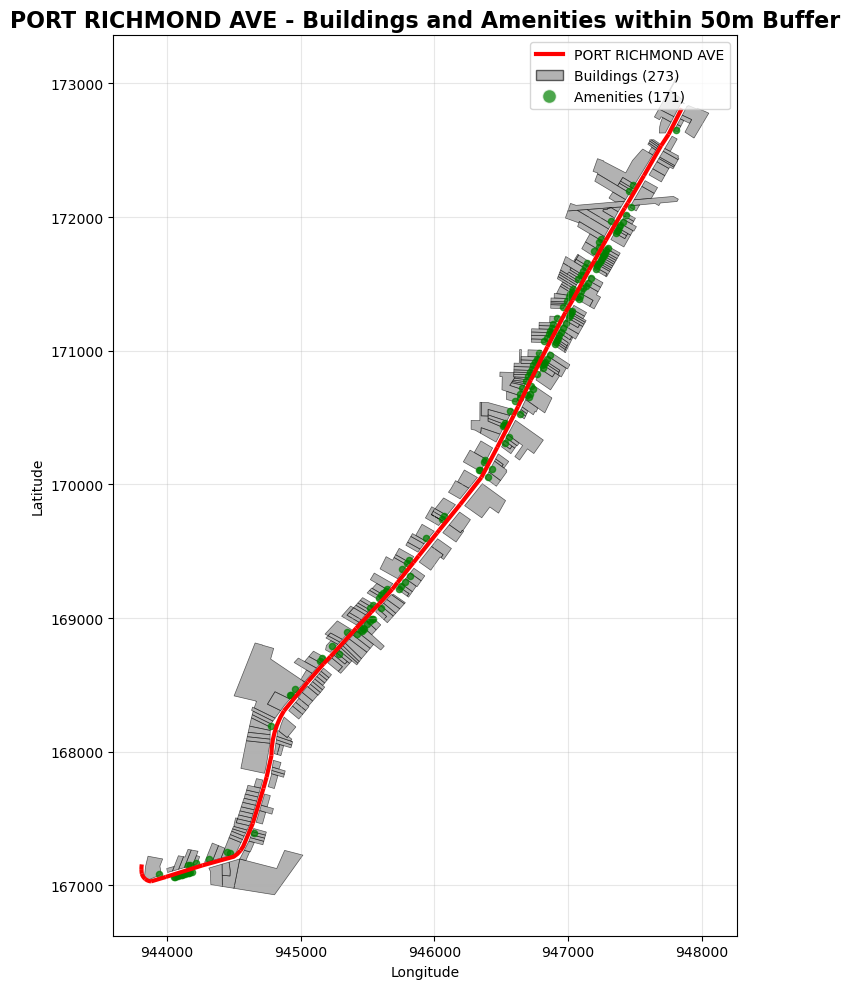


Visualization complete!


In [35]:
# Optional: Visualize the filtered data
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(15, 10))

# Plot the road
port_richmond_roads.plot(ax=ax, color='red', linewidth=3, label='PORT RICHMOND AVE')

# Plot filtered buildings
if len(buildings_filtered) > 0:
    buildings_filtered.plot(ax=ax, color='gray', alpha=0.6, edgecolor='black', linewidth=0.5, label='Buildings')

# Plot filtered amenities
if len(amenities_filtered) > 0:
    amenities_filtered.plot(ax=ax, color='green', marker='o', markersize=20, alpha=0.7, label='Amenities')

# Set title and labels
ax.set_title('PORT RICHMOND AVE - Buildings and Amenities within 50m Buffer', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='red', linewidth=3, label='PORT RICHMOND AVE'),
    Patch(facecolor='gray', edgecolor='black', alpha=0.6, label=f'Buildings ({len(buildings_filtered)})'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, alpha=0.7, label=f'Amenities ({len(amenities_filtered)})')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")

# Statistical Summary - PORT RICHMOND AVE (50m Buffer)

In [36]:
import pandas as pd
# 1. AMENITY DISTRIBUTION BY CATEGORY
print("="*70)
print("1. AMENITY DISTRIBUTION BY CATEGORY")
print("="*70)

# Check if category column exists
if 'category' in amenities_filtered.columns:
    amenity_category_dist = amenities_filtered['category'].value_counts()
    amenity_category_pct = amenities_filtered['category'].value_counts(normalize=True) * 100
    
    print(f"\nTotal amenities: {len(amenities_filtered)}")
    print(f"Number of unique categories: {amenities_filtered['category'].nunique()}")
    print("\nDistribution by Category:")
    print("-" * 70)
    
    # Create a combined dataframe for better display
    amenity_summary = pd.DataFrame({
        'Count': amenity_category_dist,
        'Percentage': amenity_category_pct.round(2)
    })
    
    print(amenity_summary.to_string())
    
else:
    # If category doesn't exist, try other common columns
    print("\n'category' column not found. Checking available columns...")
    print(f"Available columns: {amenities_filtered.columns.tolist()}")
    
    # Try alternative columns
    for col in ['class', 'subclass', 'amenity', 'type']:
        if col in amenities_filtered.columns:
            print(f"\nUsing '{col}' column instead:")
            amenity_dist = amenities_filtered[col].value_counts().head(20)
            amenity_pct = amenities_filtered[col].value_counts(normalize=True).head(20) * 100
            
            amenity_alt_summary = pd.DataFrame({
                'Count': amenity_dist,
                'Percentage': amenity_pct.round(2)
            })
            print(amenity_alt_summary.to_string())
            break

1. AMENITY DISTRIBUTION BY CATEGORY

Total amenities: 171
Number of unique categories: 4

Distribution by Category:
----------------------------------------------------------------------
                         Count  Percentage
category                                  
Urban Living               100       58.48
uncategorized               40       23.39
Industry through design     25       14.62
Other                        6        3.51


In [37]:
# 2. BUILDING TYPE DISTRIBUTION BY DISTRICT_T
print("\n" + "="*70)
print("2. BUILDING TYPE DISTRIBUTION BY DISTRICT_T")
print("="*70)

# Check if district_t column exists
if 'district_t' in buildings_filtered.columns:
    building_type_dist = buildings_filtered['district_t'].value_counts()
    building_type_pct = buildings_filtered['district_t'].value_counts(normalize=True) * 100
    
    print(f"\nTotal buildings: {len(buildings_filtered)}")
    print(f"Number of unique district types: {buildings_filtered['district_t'].nunique()}")
    print("\nDistribution by District Type:")
    print("-" * 70)
    
    # Create a combined dataframe for better display
    building_summary = pd.DataFrame({
        'Count': building_type_dist,
        'Percentage': building_type_pct.round(2)
    })
    
    print(building_summary.to_string())
    
else:
    print("\n'district_t' column not found.")
    print(f"Available columns: {buildings_filtered.columns.tolist()}")


2. BUILDING TYPE DISTRIBUTION BY DISTRICT_T

Total buildings: 273
Number of unique district types: 3

Distribution by District Type:
----------------------------------------------------------------------
               Count  Percentage
district_t                      
Commercial       159       58.24
Residential      107       39.19
Manufacturing      7        2.56


In [38]:
# 3. PERCENTAGE OF BUILDINGS WITH AMENITIES
print("\n" + "="*70)
print("3. BUILDINGS WITH AMENITIES ANALYSIS")
print("="*70)

# Check if has_amenit column exists
if 'has_amenit' in buildings_filtered.columns:
    # Overall percentage
    total_buildings = len(buildings_filtered)
    buildings_with_amenity = buildings_filtered[buildings_filtered['has_amenit'] == 1]
    count_with_amenity = len(buildings_with_amenity)
    pct_with_amenity = (count_with_amenity / total_buildings * 100) if total_buildings > 0 else 0
    
    print(f"\nOVERALL STATISTICS:")
    print("-" * 70)
    print(f"Total buildings: {total_buildings:,}")
    print(f"Buildings with amenities: {count_with_amenity:,}")
    print(f"Buildings without amenities: {total_buildings - count_with_amenity:,}")
    print(f"Percentage with amenities: {pct_with_amenity:.2f}%")
    
else:
    print("\n'has_amenit' column not found.")
    print(f"Available columns: {buildings_filtered.columns.tolist()}")


3. BUILDINGS WITH AMENITIES ANALYSIS

OVERALL STATISTICS:
----------------------------------------------------------------------
Total buildings: 273
Buildings with amenities: 135
Buildings without amenities: 138
Percentage with amenities: 49.45%


In [40]:
# 4. PERCENTAGE OF COMMERCIAL BUILDINGS WITH AMENITIES
print("\n" + "="*70)
print("4. COMMERCIAL BUILDINGS WITH AMENITIES")
print("="*70)

# Check if both columns exist
if 'has_amenit' in buildings_filtered.columns and 'district_t' in buildings_filtered.columns:
    # Filter for Commercial buildings
    commercial_buildings = buildings_filtered[buildings_filtered['district_t'] == 'Commercial']
    total_commercial = len(commercial_buildings)
    
    if total_commercial > 0:
        commercial_with_amenity = commercial_buildings[commercial_buildings['has_amenit'] == 1]
        count_commercial_with_amenity = len(commercial_with_amenity)
        pct_commercial_with_amenity = (count_commercial_with_amenity / total_commercial * 100)
        
        print(f"\nCOMMERCIAL BUILDINGS STATISTICS:")
        print("-" * 70)
        print(f"Total Commercial buildings: {total_commercial:,}")
        print(f"Commercial buildings with amenities: {count_commercial_with_amenity:,}")
        print(f"Commercial buildings without amenities: {total_commercial - count_commercial_with_amenity:,}")
        print(f"Percentage with amenities: {pct_commercial_with_amenity:.2f}%")
        
        # Comparison with overall percentage
        print(f"\nCOMPARISON:")
        print("-" * 70)
        print(f"Overall buildings with amenities: {pct_with_amenity:.2f}%")
        print(f"Commercial buildings with amenities: {pct_commercial_with_amenity:.2f}%")
        diff = pct_commercial_with_amenity - pct_with_amenity
        print(f"Difference: {diff:+.2f} percentage points")
        
        if diff > 0:
            print(f"→ Commercial buildings are {diff:.2f}% MORE likely to have amenities")
        elif diff < 0:
            print(f"→ Commercial buildings are {abs(diff):.2f}% LESS likely to have amenities")
        else:
            print(f"→ No difference in amenity presence")
    else:
        print("\nNo Commercial buildings found in the filtered dataset.")
        
else:
    print("\nRequired columns not found.")
    print(f"Available columns: {buildings_filtered.columns.tolist()}")


4. COMMERCIAL BUILDINGS WITH AMENITIES

COMMERCIAL BUILDINGS STATISTICS:
----------------------------------------------------------------------
Total Commercial buildings: 159
Commercial buildings with amenities: 104
Commercial buildings without amenities: 55
Percentage with amenities: 65.41%

COMPARISON:
----------------------------------------------------------------------
Overall buildings with amenities: 49.45%
Commercial buildings with amenities: 65.41%
Difference: +15.96 percentage points
→ Commercial buildings are 15.96% MORE likely to have amenities


In [41]:
# 5. AMENITIES BY DISTRICT TYPE (BREAKDOWN)
print("\n" + "="*70)
print("5. AMENITY PRESENCE BY DISTRICT TYPE")
print("="*70)

if 'has_amenit' in buildings_filtered.columns and 'district_t' in buildings_filtered.columns:
    print("\nAmenity Presence Breakdown by District Type:")
    print("-" * 70)
    
    # Group by district type and calculate statistics
    district_stats = []
    
    for district in buildings_filtered['district_t'].unique():
        district_buildings = buildings_filtered[buildings_filtered['district_t'] == district]
        total = len(district_buildings)
        with_amenity = len(district_buildings[district_buildings['has_amenit'] == 1])
        pct = (with_amenity / total * 100) if total > 0 else 0
        
        district_stats.append({
            'District Type': district,
            'Total Buildings': total,
            'With Amenity': with_amenity,
            'Without Amenity': total - with_amenity,
            'Percentage (%)': round(pct, 2)
        })
    
    district_df = pd.DataFrame(district_stats)
    district_df = district_df.sort_values('Percentage (%)', ascending=False)
    
    print(district_df.to_string(index=False))
    
else:
    print("\nRequired columns not found.")


5. AMENITY PRESENCE BY DISTRICT TYPE

Amenity Presence Breakdown by District Type:
----------------------------------------------------------------------
District Type  Total Buildings  With Amenity  Without Amenity  Percentage (%)
   Commercial              159           104               55           65.41
  Residential              107            30               77           28.04
Manufacturing                7             1                6           14.29


/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_82397/4037884238.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


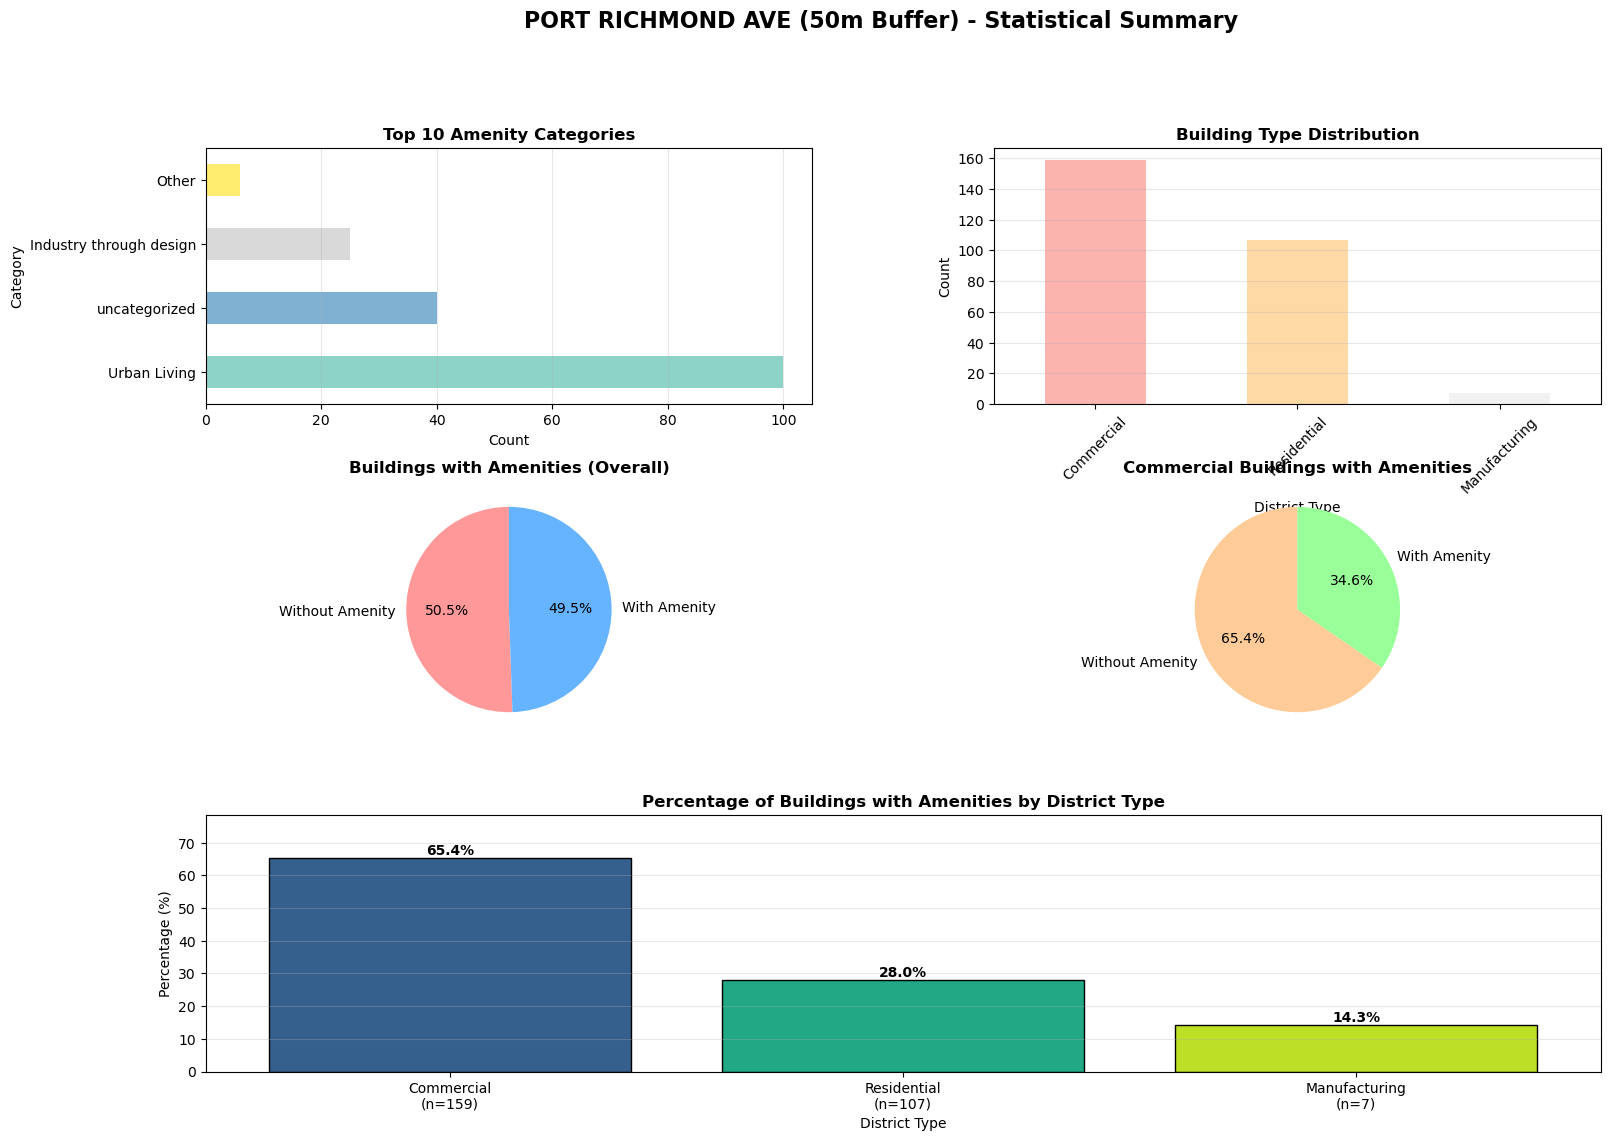


Visualization complete!


In [42]:
# 6. VISUALIZATIONS
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18, 12))

# Create a 2x3 grid of subplots
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Amenity Distribution (if category column exists)
ax1 = fig.add_subplot(gs[0, 0])
if 'category' in amenities_filtered.columns:
    amenity_counts = amenities_filtered['category'].value_counts().head(10)
    colors_amenity = plt.cm.Set3(np.linspace(0, 1, len(amenity_counts)))
    amenity_counts.plot(kind='barh', ax=ax1, color=colors_amenity)
    ax1.set_title('Top 10 Amenity Categories', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Count')
    ax1.set_ylabel('Category')
    ax1.grid(axis='x', alpha=0.3)
else:
    # Try alternative column
    for col in ['class', 'subclass', 'amenity']:
        if col in amenities_filtered.columns:
            amenity_counts = amenities_filtered[col].value_counts().head(10)
            colors_amenity = plt.cm.Set3(np.linspace(0, 1, len(amenity_counts)))
            amenity_counts.plot(kind='barh', ax=ax1, color=colors_amenity)
            ax1.set_title(f'Top 10 Amenity Types ({col})', fontsize=12, fontweight='bold')
            ax1.set_xlabel('Count')
            ax1.set_ylabel(col.capitalize())
            ax1.grid(axis='x', alpha=0.3)
            break

# Plot 2: Building Type Distribution
ax2 = fig.add_subplot(gs[0, 1])
if 'district_t' in buildings_filtered.columns:
    building_counts = buildings_filtered['district_t'].value_counts()
    colors_building = plt.cm.Pastel1(np.linspace(0, 1, len(building_counts)))
    building_counts.plot(kind='bar', ax=ax2, color=colors_building)
    ax2.set_title('Building Type Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('District Type')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

# Plot 3: Buildings with Amenities - Overall
ax3 = fig.add_subplot(gs[1, 0])
if 'has_amenit' in buildings_filtered.columns:
    amenity_counts_overall = buildings_filtered['has_amenit'].value_counts()
    labels = ['Without Amenity', 'With Amenity']
    colors = ['#ff9999', '#66b3ff']
    ax3.pie(amenity_counts_overall, labels=labels, colors=colors, autopct='%1.1f%%', 
            startangle=90, textprops={'fontsize': 10})
    ax3.set_title('Buildings with Amenities (Overall)', fontsize=12, fontweight='bold')

# Plot 4: Commercial Buildings with Amenities
ax4 = fig.add_subplot(gs[1, 1])
if 'has_amenit' in buildings_filtered.columns and 'district_t' in buildings_filtered.columns:
    commercial_buildings = buildings_filtered[buildings_filtered['district_t'] == 'Commercial']
    if len(commercial_buildings) > 0:
        commercial_amenity_counts = commercial_buildings['has_amenit'].value_counts()
        labels = ['Without Amenity', 'With Amenity']
        colors = ['#ffcc99', '#99ff99']
        ax4.pie(commercial_amenity_counts, labels=labels, colors=colors, autopct='%1.1f%%', 
                startangle=90, textprops={'fontsize': 10})
        ax4.set_title('Commercial Buildings with Amenities', fontsize=12, fontweight='bold')

# Plot 5: Amenity Presence by District Type
ax5 = fig.add_subplot(gs[2, :])
if 'has_amenit' in buildings_filtered.columns and 'district_t' in buildings_filtered.columns:
    district_amenity_pct = []
    district_labels = []
    
    for district in buildings_filtered['district_t'].unique():
        district_buildings = buildings_filtered[buildings_filtered['district_t'] == district]
        if len(district_buildings) > 0:
            pct = (district_buildings['has_amenit'] == 1).sum() / len(district_buildings) * 100
            district_amenity_pct.append(pct)
            district_labels.append(f"{district}\n(n={len(district_buildings)})")
    
    # Sort by percentage
    sorted_indices = np.argsort(district_amenity_pct)[::-1]
    district_amenity_pct = [district_amenity_pct[i] for i in sorted_indices]
    district_labels = [district_labels[i] for i in sorted_indices]
    
    colors_bars = plt.cm.viridis(np.linspace(0.3, 0.9, len(district_amenity_pct)))
    bars = ax5.bar(district_labels, district_amenity_pct, color=colors_bars, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax5.set_title('Percentage of Buildings with Amenities by District Type', fontsize=12, fontweight='bold')
    ax5.set_xlabel('District Type', fontsize=10)
    ax5.set_ylabel('Percentage (%)', fontsize=10)
    ax5.grid(axis='y', alpha=0.3)
    ax5.set_ylim(0, max(district_amenity_pct) * 1.2 if district_amenity_pct else 100)

plt.suptitle('PORT RICHMOND AVE (50m Buffer) - Statistical Summary', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")